# Reading in Results

In [23]:
import math
from bestreads import text
from bestreads.text.metrics import rbo
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
import seaborn as sbn

sbn.set_style('whitegrid')

data_dir = './data/processed/'
processed_data_train = pd.read_csv(
    data_dir + 'goodreads_books_train_processed.csv', index_col=0)
processed_data_val = pd.read_csv(
    data_dir + 'goodreads_books_val_processed.csv', index_col=0)
tf_idf_table = pd.read_csv(
    data_dir + 'tf_idf_table_train.csv', index_col=0)

In [2]:
genre_and_votes_val = processed_data_val[['genre_1', 'votes_1']]
cleaned_descriptions_val = processed_data_val['cleaned_descriptions']

In [3]:
tf_idf_table.head()

,Speculative Fiction,Historical,Writing,Reference,War,Shapeshifters,Race,Plays,Horror,Holiday,...,Politics,Poetry,LGBT,Literature,Paranormal,Science Fiction,Romance,Fantasy,Space,Literary Fiction
word,,,,,,,,,,,,,,,,,,,,,
thi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
futur,0.000277,0.000045,0.000029,0.000005,0.000038,0.000052,0.000017,0.000043,0.000014,0.000000,...,0.000054,0.000010,0.000028,0.000014,0.000006,0.000125,0.000063,0.000065,0.000108,0.000022
peopl,0.000064,0.000040,0.000030,0.000020,0.000029,0.000018,0.000059,0.000022,0.000046,0.000000,...,0.000040,0.000008,0.000023,0.000027,0.000012,0.000034,0.000022,0.000026,0.000028,0.000027
need,0.000059,0.000037,0.000044,0.000131,0.000075,0.000195,0.000012,0.000026,0.000085,0.000000,...,0.000073,0.000023,0.000131,0.000017,0.000079,0.000080,0.000156,0.000097,0.000047,0.000040
sleep,0.000193,0.000035,0.000036,0.000123,0.000050,0.000053,0.000000,0.000021,0.000124,0.000222,...,0.000000,0.000017,0.000000,0.000024,0.000054,0.000023,0.000040,0.000000,0.000085,0.000000


## Metrics

We can plot what the weighting of the rank-biased order (RBO) evaluation metric cumulative weight looks like for different choices of the parameter p.

In [3]:
# This function is a hot mess, but it calculates the fraction of the total weight in the RBO
# that is associated with the first d terms given a choice of 0 < p < 1.  Large values of p
# will give more weight to terms lower down the list while smaller values weight the top
# values more heavily.

def rbo_weight(p, d):
    def sum_series(p, d):
        # tail recursive helper function
        def helper(ret, p, d, i):
            term = math.pow(p, i)/i
            if d == i:
                return ret + term
            return helper(ret + term, p, d, i+1)
        return helper(0, p, d, 1)

    return (1 - math.pow(p, d-1) 
            + (((1-p)/p) * d *(np.log(1/(1-p))
                               - sum_series(p, d-1))))

Text(0, 0.5, 'Cumulative Weight')

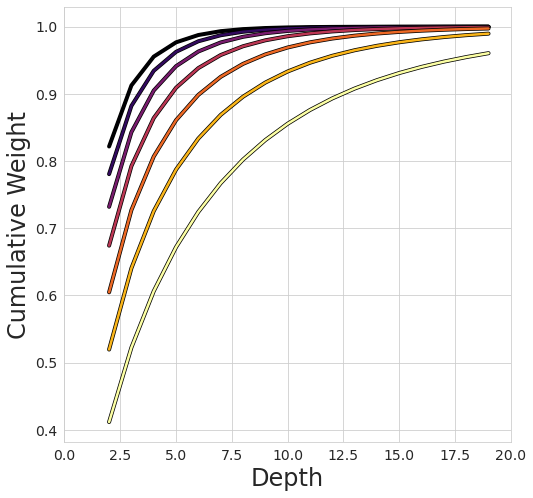

In [27]:
fig = plt.figure(figsize = (8, 8))
sp = fig.add_subplot(111)

d_grid = np.arange(18)+2
p_grid = np.arange(0.6, 0.95, 0.05)
colors = [mpl.cm.inferno(int(place)) for place in np.linspace(0, mpl.cm.inferno.N, len(p_grid))]

for p, color in zip(p_grid, colors):
    weight_list = []
    for d in d_grid:
        weight_list.append(rbo_weight(p,d))
    
    sp.plot(d_grid, weight_list, color=color, 
            path_effects=[pe.Stroke(linewidth = 4, foreground = 'k'), pe.Normal()],
            linewidth=2.5)

sp.set_xlim(0, 20)
sp.set_xlabel('Depth')
sp.set_ylabel('Cumulative Weight')

## Validation

In [9]:
rbo_list = []

temp_descriptions = cleaned_descriptions_val.sample(n=100)

for description in tqdm(temp_descriptions):
    result = text.query(description, tf_idf_table)
    rbo_list.append(rbo(result, genre_and_votes_val.filter(like='genre')))



NameError: name 'cleaned_descriptions_val' is not defined

In [ ]:
## Plot the histogram of RBO values

# Old Validation (delete later)

In [4]:
# Here, I will pull from the top 5 genres, but this could be modified later
n=5
column_names = [f'{stub}_{num+1}' 
                for num in range(n)
                for stub in ['genre', 'score']]
predicted_genres_and_scores = {key:[] for key in column_names}

temp_descriptions = cleaned_descriptions_val.sample(n=100)

for description in tqdm(temp_descriptions):
    result = text.query(description, tf_idf_table).iloc[:n]
    for idx in range(n):
        predicted_genres_and_scores[f'genre_{idx+1}'].append(result.index[idx])
        predicted_genres_and_scores[f'score_{idx+1}'].append(result.iloc[idx])
predicted_genres_and_scores = pd.DataFrame.from_dict(predicted_genres_and_scores)
predicted_genres_and_scores.index = temp_descriptions.index

100%|█████████████████████████████████████████| 100/100 [10:42<00:00,  6.42s/it]


In [5]:
correct = []
for true_genre, predicted_genres in zip(genre_and_votes_val['genre_1'].loc[predicted_genres_and_scores.index],
                                        predicted_genres_and_scores
                                        .filter(like='genre').values):
    if true_genre in predicted_genres:
        correct.append(True)
    elif true_genre is not np.nan:
        correct.append(False)

In [6]:
sum(correct)/len(correct)

0.6352941176470588